<b>Replication of results achieved in paper "Towards Pricing Financial Derivatives with an IBM Quantum Computer" (Martin et. al 2019) using QISKIT</b>

In [2]:
!pip install qiskit

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [4]:
import numpy as np
import scipy
from qiskit import(
  QuantumCircuit,
  execute,
  BasicAer,
  QuantumRegister,
  ClassicalRegister)
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.synthesis import euler_angles_1q 

Presenting the classical implementation of PCA, on a simple dataset. 
<br>The dataset is represented as a matrix: each row is a sample and each column is a variable whose value has been measured.
First the data is standardized, then the covariance matrix is computed and divided by its trace to normalize it.
<br>Let's suppose we get to this normalized covariance matrix $$\rho = \begin{pmatrix} 0.6407 & 0.3288 \\ 0.3288 & 0.3593\end{pmatrix}$$
<br>The algorithm proceeds by computing the eigenvalues and eigenvectors of such matrix

In [6]:
covmat=[[0.6407, 0.3288],[0.3288, 0.3593]]
eigval, eigvec = np.linalg.eig(covmat)
eva=eigval[np.argsort(eigval)[::-1]]
evs=eigvec[:,np.argsort(eigval)[::-1]]
print("Eigenvalues: ")
print(eva)
print("Eigenvectors: ")
print(evs)

Eigenvalues: 
[0.85763939 0.14236061]
Eigenvectors: 
[[ 0.83468948 -0.55072087]
 [ 0.55072087  0.83468948]]


This step, performed classically, typically runs in $ O (n^3) $ (where $ n $ is the number of variables), depending on the implementation.
<br>What we really need to perform PCA is the first (largest) eigenvalue and corresponding eigenvector, that will be used to transform the original dataset and obtain its one-dimensional representation.
<br>We will exploit a quantum circuit in order to approximate such largest eigenvalue.

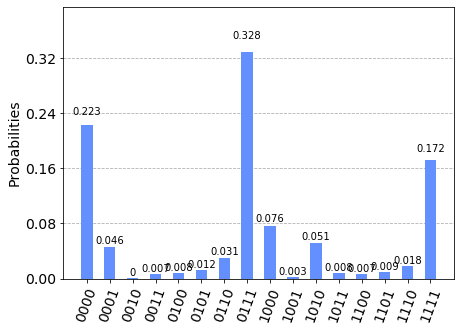

In [15]:
simulator = BasicAer.get_backend('qasm_simulator')
circuit = QuantumCircuit(4, 4)

#gate preparation
u = np.round(scipy.linalg.expm(2*np.pi*1j*np.array(covmat)),4)
u = euler_angles_1q(u)

#superposition
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)

#U3 chain
circuit.cu3(u[0],u[1],u[2],2,3)

circuit.cu3(u[0],u[1],u[2],1,3)
circuit.cu3(u[0],u[1],u[2],1,3)

circuit.cu3(u[0],u[1],u[2],0,3)
circuit.cu3(u[0],u[1],u[2],0,3)
circuit.cu3(u[0],u[1],u[2],0,3)
circuit.cu3(u[0],u[1],u[2],0,3)


#Second step
circuit.h(0)
circuit.cu1(-np.pi/2,0,1)
circuit.cu1(-np.pi/4,0,2)
circuit.h(1)
circuit.cu1(-np.pi/2,1,2)
circuit.h(2)


circuit.measure([0,1,2,3],[0,1,2,3])

job = execute(circuit, simulator, shots=8192)
result = job.result().data(circuit)

plot_histogram(job.result().get_counts())

To estimate the largest eigenvalue, we look at the values of the last 3 qubits.
<br>The two configurations $ 0111 $ and $ 1111 $ combined have the largest outcome probability, and the expected result is in fact $ 111 $, that is the best approximation of the value $ 0.8576 $ with this number of bits.